In [9]:
from stats import *
from utils import TableBuilder as table, PROJECTS
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

List of study subjects. These were selected from https://github.com/Spirals-Team/open-science-repairnator and https://github.com/STAMP-project/descartes-experiments.

In [2]:
table('Project').display(PROJECTS)

Project
jpush-api-java-client
commons-cli
jopt-simple
yahoofinance-api
gson-fire
j2html
spring-petclinic
javapoet
eaxy
java-html-sanitizer


Now, we load all the differences we found after the execution of our three stages process.

In [4]:
all_diffs = [ get_diffs_for_project(f'../../subjects/{pro}') for pro in PROJECTS ]

These differences were computed for each undetected extreme transformations discovered with [Descartes](https://gituhb.com/STAMP-project/pitest-descartes).
So, the following snippet shows the number of undetected extreme transformations for each study subjects.

In [5]:
table('Project', 'Transformations').display((p, len(d)) for p,d in zip(PROJECTS, all_diffs))

Project,Transformations
jpush-api-java-client,2
commons-cli,5
jopt-simple,7
yahoofinance-api,5
gson-fire,4
j2html,5
spring-petclinic,6
javapoet,10
eaxy,14
java-html-sanitizer,14


Each difference item is represented here as a tuple with, the mutant information, all value mistmatches found in the propagation analysis and the same for the infection analysis.
Form the collected difference items we can identify the symptom for each undetected extreme transformation, that is : **no-infection**, **no-propagation** and **weak-oracle**.

In [7]:
is_no_infection = lambda d: not d[2]
is_no_propagation = lambda d: d[2] and not d[1]
is_weak_oracle = lambda d: d[1] and d[2]

is_infection = lambda d: bool(len(d[2]))

DIFF2SYMPOT = {
    'no-infection': is_no_infection,
    "no-propagation": is_no_propagation,
    "weak-oracle": is_weak_oracle
}

def count(values):
    return len(list(values))

def get_symptom(difference):
    for symptom, function in DIFF2SYMPOT.items():
        if function(difference):
            return symptom

def count_symptoms(difference):
    return count(d for d in difference if is_no_infection(d)), count(d for d in difference if is_no_propagation(d)), count(d for d in difference if is_weak_oracle(d))
    
symptom_count_project = [ count_symptoms(diff) for diff in all_diffs ]

table('Project', 'no-infection', 'no-propagation', 'weak-oracle').display((proj, ni, np, wo) for proj, (ni, np, wo) in zip(PROJECTS, symptom_count_project))

Project,no-infection,no-propagation,weak-oracle
jpush-api-java-client,1,0,1
commons-cli,0,2,3
jopt-simple,1,4,2
yahoofinance-api,0,4,1
gson-fire,3,0,1
j2html,5,0,0
spring-petclinic,1,4,1
javapoet,8,1,1
eaxy,2,9,3
java-html-sanitizer,5,7,2


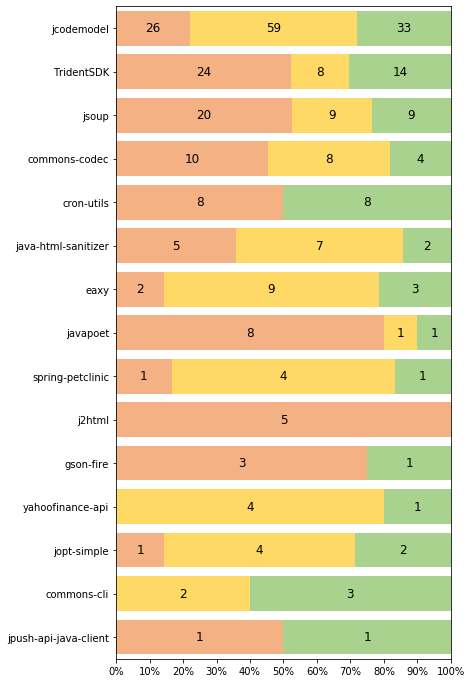

In [13]:
NO_INFECTION_COLOR = (244/255,177/255,131/255)
NO_PROPAGATION_COLOR = (1,217/255,102/255)
WEAK_ORACLE_COLOR = (169/255,210/255,142/255)

no_infection   = np.array([x for x, _, _ in symptom_count_project])
no_propagation = np.array([x for _, x, _ in symptom_count_project])
weak_oracle    = np.array([x for _, _, x in symptom_count_project])

total = no_infection + no_propagation + weak_oracle

normalize = lambda arr: np.divide(arr, total)

nni = normalize(no_infection)
nnp = normalize(no_propagation)
nwo = normalize(weak_oracle)

y_ticks = range(len(PROJECTS))

from matplotlib.ticker import PercentFormatter, MultipleLocator

plt.rcParams['figure.figsize'] = [6, 12]

NO_INFECTION_COLOR = (244/255,177/255,131/255)
NO_PROPAGATION_COLOR = (1,217/255,102/255)
WEAK_ORACLE_COLOR = (169/255,210/255,142/255)

plt.xticks(np.arange(0., 1.1, step=.1))
plt.xlim(-0.1, 1.1)
plt.ylim(-.5, len(PROJECTS) -.5)

ax = plt.gca()
ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))
ax.yaxis.set_minor_locator(MultipleLocator(1))

text = lambda x, y, value: ax.text(
    x, y, str(value), 
    horizontalalignment='center', 
    verticalalignment='center',
    fontsize='large'
)
def datalabels(values, labels, left=[]):
    left = np.zeros_like(values) if not len(left) else left
    for val, xoff, y, label in zip(values, left, y_ticks, labels):
        if val:
            text(xoff + val/2, y, label)

plt.yticks(y_ticks, PROJECTS)

plt.barh(y_ticks, nni, color=NO_INFECTION_COLOR)
datalabels(nni, no_infection)

plt.barh(y_ticks, nnp, left=nni, color=NO_PROPAGATION_COLOR)
datalabels(nnp, no_propagation, nni)

plt.barh(y_ticks, nwo, left=nni + nnp, color=WEAK_ORACLE_COLOR)
datalabels(nwo, weak_oracle, nni + nnp)

plt.xlim(0, 1)
plt.show()

In [7]:
def mutation2json(mutation):
    return {
        'mutator': mutation.mutator,
        'package': mutation.package,
        'class': mutation.class_name,
        'method': mutation.method,
        'description': mutation.description,
    }

for project, diff in zip(projects, all_diffs):
    print(project)
    data = { key : [] for key in DIFF2SYMPOT.keys() }
    for d in diff:
        data[get_symptom(d)].append(mutation2json(d[0]))
    with open(f'../../subjects/{project}/results/symptoms.json', 'w') as _file:
        json.dump(data, _file, indent=2)

jpush-api-java-client
commons-cli
jopt-simple
yahoofinance-api
gson-fire
j2html
spring-petclinic
javapoet
eaxy
java-html-sanitizer
cron-utils
commons-codec
jsoup
TridentSDK
jcodemodel


## Where are the infections visible?

Each value mismatch has a descriptior of the code element or location where is was found. With this, we can identify, for example, if the infection occurred in the result of the method, the arguments or the instance in which the method was invoked.


We explore now, how many times, in a method with parameters, the infection can be discovered in the state of the arguments.

In [15]:
import re
ARG_REO = re.compile('\|#\d+')
has_parameters = lambda d: not '()' in d[0].description
infection_in_argument = lambda d: any( bool(ARG_REO.search(i['pointcut'])) for i in d[2])
table(
    'Project', 
    'Methods with parameters', 
    'Infections in methods with parameters', 
    'Infection visible in arguments'
).display(
    (
        proj,
        count(d for d in diff if has_parameters(d)),
        count(d for d in diff if has_parameters(d) and is_infection(d)),
        count(d for d in diff if has_parameters(d) and infection_in_argument(d))
    ) for proj, diff in zip(PROJECTS, all_diffs)
)

Project,Methods with parameters,Infections in methods with parameters,Infection visible in arguments
jpush-api-java-client,1,0,0
commons-cli,4,4,0
jopt-simple,7,6,0
yahoofinance-api,5,5,0
gson-fire,4,1,1
j2html,1,0,0
spring-petclinic,6,5,4
javapoet,9,1,1
eaxy,7,5,0
java-html-sanitizer,10,5,2


We now explore, how frequently the infection was observed in the result of the method invocations.

In [16]:
is_not_void = lambda d: not ')V' in d[0].description
infection_in_result = lambda d: any('|#result' in i['pointcut'] for i in d[2])

table(
    'Project',
    'Non-void methods',
    'Infections in non-void methods',
    'Infections visible in the result'
).display(
    (
        proj, 
        count(d for d in diff if is_not_void(d)), 
        count(d for d in diff if is_not_void(d) and is_infection(d)), 
        count(d for d in diff if is_not_void(d) and is_infection(d) and infection_in_result(d))
    ) for proj, diff in zip(PROJECTS, all_diffs)
)

Project,Non-void methods,Infections in non-void methods,Infections visible in the result
jpush-api-java-client,2,1,1
commons-cli,5,5,5
jopt-simple,7,6,6
yahoofinance-api,5,5,5
gson-fire,4,1,1
j2html,1,0,0
spring-petclinic,2,1,0
javapoet,9,2,2
eaxy,12,11,10
java-html-sanitizer,9,7,5


We now explore how frequently the infection is observed in the instance on which the method was invoked.

In [18]:
import json

def get_static_methods(path):
    with open(path) as _file:
        data = json.load(_file)
        return set(f'{r["package"]}/{r["class"]}/{r["name"]}{r["description"]}' for r in data if "STATIC" in r["classifications"])

static_methods = [ get_static_methods(f'../../subjects/{name}/results/inspected-methods.json') for name in PROJECTS ]

def full_description(d):
    package = d[0].package.replace('.', '/')
    return f'{package}/{d[0].class_name}/{d[0].method}{d[0].description}'

infection_in_instance = lambda d: any('|#that' in i['pointcut'] for i in d[2])

not_in = lambda d, methods: not full_description(d) in methods
                   
table(
    'Project',
    'Non-static methods',
    'Infections in non-static methods',
    'Infections visible in the instance'
).display(
    (
        proj, 
        count(d for d in diff if not_in(d, st_methods)), 
        count(d for d in diff if not_in(d, st_methods) and is_infection(d)), 
        count(d for d in diff if not_in(d, st_methods) and is_infection(d) and infection_in_instance(d))
        
    ) for proj, diff, st_methods in zip(PROJECTS, all_diffs, static_methods)
)

Project,Non-static methods,Infections in non-static methods,Infections visible in the instance
jpush-api-java-client,1,0,0
commons-cli,2,2,0
jopt-simple,6,6,0
yahoofinance-api,0,0,0
gson-fire,3,1,1
j2html,5,0,0
spring-petclinic,6,5,2
javapoet,8,1,1
eaxy,14,12,5
java-html-sanitizer,7,6,2


`boolean` methods deserve a targeted analysis.

In [19]:
is_boolean = lambda m: ')Z' in m[0].description
table(
    'Project', 
    'boolean methods', 
    'boolean methods with no-infection'
).display(
    (
        proj, 
        count(d for d in diff if is_boolean(d)),
        count(d for d in diff if is_boolean(d) and is_no_infection(d))
    ) for proj, diff in zip(PROJECTS, all_diffs)
)

Project,boolean methods,boolean methods with no-infection
jpush-api-java-client,1,1
commons-cli,2,0
jopt-simple,1,1
yahoofinance-api,1,0
gson-fire,3,3
j2html,1,1
spring-petclinic,1,1
javapoet,7,7
eaxy,4,1
java-html-sanitizer,6,2


Inside `boolean` methods, in no `equals` method related to an undetected extreme transformation we observed a program infection. These methods were tested to return only one value.

In [20]:
is_equals_method = lambda m: 'equals' == m[0].method
table(
    'Project', 
    'equals methods', 
    'equals methods with no-infection'
).display(
    (
        proj, 
        count(d for d in diff if is_equals_method(d)),
        count(d for d in diff if is_equals_method(d) and is_no_infection(d))
    ) for proj, diff in zip(PROJECTS, all_diffs)
)

Project,equals methods,equals methods with no-infection
jpush-api-java-client,0,0
commons-cli,0,0
jopt-simple,0,0
yahoofinance-api,0,0
gson-fire,2,2
j2html,1,1
spring-petclinic,0,0
javapoet,6,6
eaxy,1,1
java-html-sanitizer,0,0


The following plots show the distribution of observable points that were used to inspect the state of the program after the method invocations.

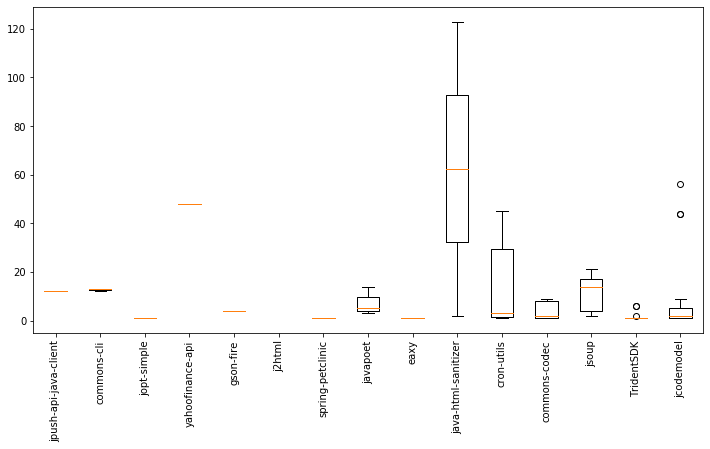

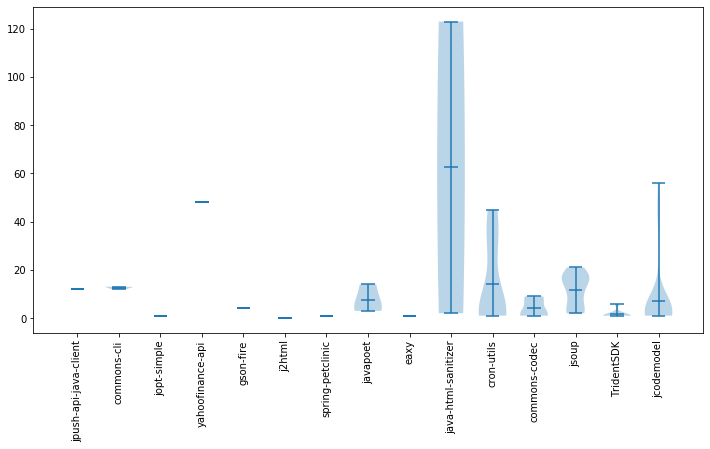

In [22]:
observable_points = [[ len(m[1]) for m in p if m[1] ]  for p in all_diffs ]

plt.rcParams['figure.figsize'] = [12, 6]

plt.boxplot(observable_points)
plt.xticks(range(1, len(PROJECTS)+1), PROJECTS, rotation=90)
plt.show()

nans = [0, 0]

opd_positions = [1.5*i for i in range(len(PROJECTS))] 

plt.xticks(opd_positions, PROJECTS, rotation=90)
parts = plt.violinplot(
    [pts or nans for pts in observable_points], 
    widths=1, 
    showmeans=True, 
    positions=opd_positions
)
plt.show()

## Stack distance for no-propagation and weak-oracle symptoms

We explore now the stack distance to the test case of the methods with **no-propagation** and **weak-oracle** symptoms. The stack distance is the number of activation records between the activation record of the test case and the method related to the transformation. If the method is invoked more than once, then we keep the lowest stack distance.

In [23]:
def get_distances(path):
    with open(path) as _file:
        data = json.load(_file)
        return {d['method']:min([ min(t['distances']) for t in d['tests']]) for d in data}
distance_to_tests = [ get_distances(f'../../subjects/{name}/results/stack-distance.json') for name in PROJECTS]

def get_distance_distributions(diff, distances):
    no_propagation = []
    weak_oracle = []
    for d in diff:
        if not is_infection(d):
            continue
        method = full_description(d)
        if not method in distances:
            print(method)
            continue # Distance was not recorded
        distance = distances[method]
        ( weak_oracle if is_weak_oracle(d) else no_propagation ).append(distance)
    return no_propagation, weak_oracle

distance_distributions = [ get_distance_distributions(diff, distances) for diff, distances in zip(all_diffs, distance_to_tests) ]

org/eaxy/experimental/SampleSoapXmlBuilder/getFilename()Ljava/lang/String;
org/eaxy/experimental/SampleSoapXmlBuilder/getFilename()Ljava/lang/String;
org/eaxy/experimental/SampleSoapXmlBuilder/getFilename()Ljava/lang/String;


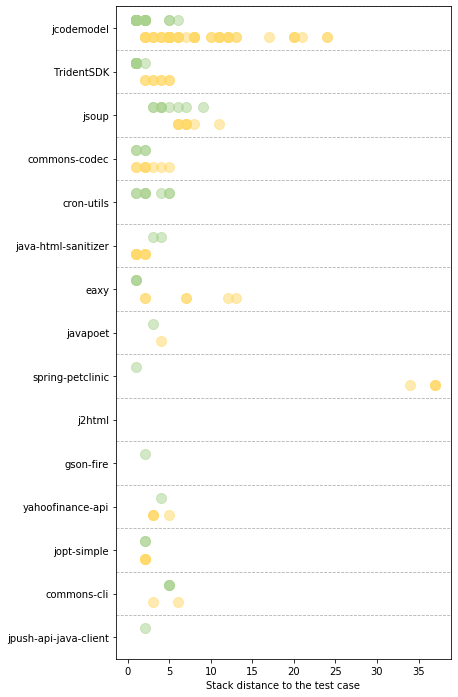

In [44]:

plt.rcParams['figure.figsize'] = [6, 12]

from matplotlib.ticker import MultipleLocator

for proj, dists, x in zip(PROJECTS, distance_distributions, range(len(PROJECTS))):
    no_propagation_distances, weak_oracle_distances = dists
    #print(no_propagation_distances)
    #print(weak_oracle_distances)
    plt.scatter(no_propagation_distances, [x - .2]*len(no_propagation_distances), c=[NO_PROPAGATION_COLOR], alpha=.5, s=100)
    plt.scatter( weak_oracle_distances, [x + .2]*len(weak_oracle_distances), c=[WEAK_ORACLE_COLOR], alpha=.5, s=100)

ax = plt.gca()
ax.yaxis.set_minor_locator(MultipleLocator(.5))
ax.tick_params(which='minor', length=0)

plt.ylim(-.5, len(PROJECTS) - .5)
plt.xlabel('Stack distance to the test case')
plt.yticks(range(len(PROJECTS)), PROJECTS)
plt.grid(True, axis='y', linestyle='--', which='minor')
plt.savefig('distance-scatter-vertical.pdf', dpi=300,bbox_inches='tight')
plt.show()

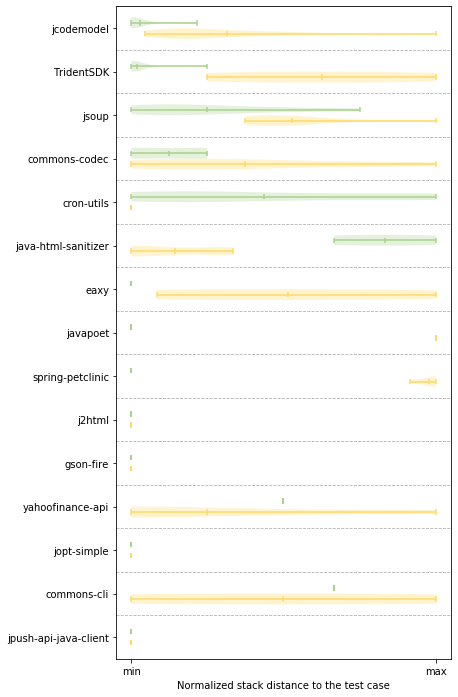

In [42]:
plt.rcParams['figure.figsize'] = [6, 12]
def normalize_distances(distances):
    no_prop, weak_orc = distances
    if not no_prop and not weak_orc:
        return (no_prop, weak_orc)
    minimum, maximum = min(no_prop + weak_orc), max(no_prop + weak_orc)
    scale = 1 / (maximum - minimum  + 0.000001)
    transform = lambda l: l if not l else [(d - minimum)*scale for d in l ]
    return transform(no_prop), transform(weak_orc)

normalized_distances = [ normalize_distances(dists) for dists in distance_distributions ]

def set_violin_color(parts, color):
    for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
        if partname not in parts:
            continue
        vp = parts[partname]
        vp.set_edgecolor(color)
    for body in parts['bodies']:
        body.set_facecolor(color)
        

tick_step = 4        
ax = plt.gca()
ax.yaxis.set_minor_locator(MultipleLocator(4))
ax.tick_params(which='minor', length=0)
plt.grid(axis='y', linestyle='--', which='minor')
plt.ylim(0,len(PROJECTS)*tick_step)
yticks_distance_dist = [ tick_step * i + tick_step/2 for i in range(len(PROJECTS)) ]
plt.yticks(yticks_distance_dist, PROJECTS)
plt.xticks( [0, 1], ['min', 'max'] )
plt.xlabel('Normalized stack distance to the test case')
parts = plt.violinplot([d or nans for d,_ in normalized_distances], vert=False, widths=1, showmeans=True, positions=[y - .5 for y in yticks_distance_dist ])
set_violin_color(parts, NO_PROPAGATION_COLOR)
parts = plt.violinplot([d or nans for _,d in normalized_distances], vert=False, widths=1, showmeans=True, positions=[y + .5 for y in yticks_distance_dist ])
set_violin_color(parts, WEAK_ORACLE_COLOR)
# plt.savefig('distance-distributions.pdf', dpi=300, bbox_inches='tight')
plt.show() # IMPORTANT! savefig before show, otherwise you get an empty image

We now use Cohen's d to see if there is a significative difference between the distance of these two groups of symptoms.

In [43]:
from statistics import mean, stdev
from math import sqrt
cohens_d = lambda a, b: (mean(a) - mean(b)) / (sqrt((stdev(a) ** 2 + stdev(b) ** 2) / 2))

size_effect_values = []

for proj, distances in zip(PROJECTS, distance_distributions):
    try:
        if distances[0] and distances[1]:
            effect = cohens_d(*distances)
            size_effect_values.append((proj, effect, abs(effect) >= .8))
    except:
        pass
    
table('Project', 'Size effect', 'Is it significative?').display(size_effect_values)

Project,Size effect,Is it significative?
commons-cli,-0.33333333333333337,False
eaxy,1.8523168449905083,True
java-html-sanitizer,-3.3048567173295,True
commons-codec,0.9258200997725514,True
jsoup,1.2379689211803457,True
TridentSDK,2.804272736063897,True
jcodemodel,1.6195907613344371,True
